## Importing Libraries

In [343]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import pickle
from mlxtend.data import loadlocal_mnist

## Setting Numpy Seed

In [344]:
np.random.seed(10)

## Processing MNIST Dataset

In [345]:
def process_mnist_data() -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    mnist_path = './MNIST/'
    train_images, train_labels = loadlocal_mnist(
        images_path = mnist_path + './train-images.idx3-ubyte',
        labels_path = mnist_path + './train-labels.idx1-ubyte'
    )
    test_images, test_labels = loadlocal_mnist(
        images_path = mnist_path + './t10k-images.idx3-ubyte',
        labels_path = mnist_path + './t10k-labels.idx1-ubyte'
    )
    return train_images, train_labels, test_images, test_labels

## Processing CIFAR-10 Dataset

In [346]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

In [347]:
def process_cifar_dataset() -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    cifar_path = './cifar-10-python/cifar-10-batches-py'
    data_batch = unpickle(cifar_path + '/data_batch_1')
    train_images, train_labels = data_batch[b'data'], np.array(data_batch[b'labels'])
    for i in range(2,6):
        data_batch = unpickle(cifar_path + '/data_batch_' + str(i))
        train_images = np.concatenate((train_images, data_batch[b'data']), axis=0)
        train_labels = np.concatenate((train_labels, np.array(data_batch[b'labels'])), axis=0)
    test_batch = unpickle(cifar_path + '/test_batch')
    test_images, test_labels = test_batch[b'data'], np.array(test_batch[b'labels'])
    return train_images, train_labels, test_images, test_labels

## Processing Toy Dataset

In [348]:
def process_toy_dataset():
    toy_dataset_path = './Toy Dataset/'
    a = np.loadtxt(toy_dataset_path + 'trainNN.txt')
    b = np.loadtxt(toy_dataset_path + 'testNN.txt')
    train_x, train_y, test_x, test_y = a[:, 0:4], a[:, -1], b[:, 0:4], b[:, -1]
    return train_x, train_y, test_x, test_y

In [349]:
x_train_toy, y_train_toy, x_test_toy, y_test_toy = process_toy_dataset()
toy_batch_1 = x_train_toy[0:50].reshape(50, 1, 2, 2)
toy_batch_1[0, 0, :, :]

array([[ 9.21323266, 11.82445528],
       [16.69098092, 19.56967227]])

In [350]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(1,5))
toy_labels_1 = label_binarizer.transform(y_train_toy[0:50].T)
toy_labels_1

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1,

## Parsing Input Model

In [351]:
def parse_input_model():
    path = './input_model.txt'
    model = []
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            tokens = line.split()
            if tokens[0] == 'Conv':
                model.append(ConvolutionLayerBatch(int(tokens[1]), int(tokens[2]), int(tokens[3]), int(tokens[4])))
            if tokens[0] == 'ReLU':
                model.append(ActivationLayer())
            if tokens[0] == 'Pool':
                model.append(MaxPoolingLayerBatch(int(tokens[1]), int(tokens[2])))
            if tokens[0] == 'FC':
                model.append(FlatteningLayerBatch())
                model.append(FullyConnectedLayerBatch(int(tokens[1])))
            if tokens[0] == 'Softmax':
                model.append(SoftmaxLayerBatch())
        return model

## ReLU and ReLU Derivative Functions

In [352]:
def relu(matrix:np.ndarray) -> np.ndarray:
    return matrix * (matrix > 0)

In [353]:
def relu_derivative(matrix: np.ndarray) -> np.ndarray:
    return (matrix > 0) * 1.0

## Convolution Layer

In [354]:
class ConvolutionLayer:
    def __init__(self, output_channel_count: int, filter_dimension: int, stride: int, padding: int):
        self.output_channel_count = output_channel_count
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.padding = padding

    def forward(self, input_image: np.ndarray) -> np.ndarray:
        input_dimentions = input_image.shape[0]
        output_dimentions = (input_dimentions - self.filter_dimension + 2 * self.padding) // self.stride + 1
        input_shape = input_image.shape

        filters = np.random.rand(
            self.output_channel_count,
            self.filter_dimension,
            self.filter_dimension,
            input_shape[2]
        )

        bias = np.random.rand(self.output_channel_count)

        padded_image = np.pad(input_image, [(self.padding,self.padding), (self.padding,self.padding), (0,0)], mode='constant') * 1.0
        padded_image /= 255.0
        padded_dimensions = padded_image.shape

        output = np.zeros((output_dimentions, output_dimentions, self.output_channel_count))

        image_y = out_y = 0
        while image_y + self.filter_dimension <= padded_dimensions[1]:
            image_x = out_x = 0
            while image_x + self.filter_dimension <= padded_dimensions[0]:
                image_slice = padded_image[image_x:image_x+self.filter_dimension, image_y:image_y+self.filter_dimension, :]
                output[out_x, out_y, :] = np.sum(image_slice * filters) + bias
                image_x += self.stride
                out_x += 1
            image_y += self.stride
            out_y += 1

        return output

    def backward(self):
        pass

In [355]:
class ConvolutionLayerBatch:
    def __init__(self, output_channel_count: int, filter_dimension: int, stride: int, padding: int):
        self.output_channel_count = output_channel_count
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.padding = padding
        self.bias = None
        self.filters = None
        self.input_batch = None

    def forward(self, input_batch: np.ndarray) -> np.ndarray:
        self.input_batch = input_batch

        input_dimentions = input_batch.shape
        output_dimentions = (input_dimentions[2] - self.filter_dimension + 2 * self.padding) // self.stride + 1
        input_shape = input_batch.shape

        if self.filters is None:
            self.filters = np.random.randn(
                self.output_channel_count,
                input_shape[1],
                self.filter_dimension,
                self.filter_dimension
            ) * np.sqrt(2/input_shape[1] * self.filter_dimension ** 2)

        if self.bias is None:
            self.bias = np.zeros(self.output_channel_count)

        # print('Convolution layer')
        # print(self.filters[0, 0, :, :])
        # print(self.bias)

        padded_image = np.pad(input_batch, [(0, 0), (0, 0), (self.padding,self.padding), (self.padding,self.padding)], mode='constant') * 1.0
        padded_image /= 255.0
        padded_dimensions = padded_image.shape

        output = np.zeros((input_dimentions[0], self.output_channel_count, output_dimentions, output_dimentions))

        for i in range(input_dimentions[0]):
            image_y = out_y = 0
            while image_y + self.filter_dimension <= padded_dimensions[3]:
                image_x = out_x = 0
                while image_x + self.filter_dimension <= padded_dimensions[2]:
                    image_slice = padded_image[i, :, image_x:image_x+self.filter_dimension, image_y:image_y+self.filter_dimension]
                    output[i, :, out_x, out_y] = np.sum(image_slice * self.filters) + self.bias
                    image_x += self.stride
                    out_x += 1
                image_y += self.stride
                out_y += 1

        return output

    def backward(self, dz: np.ndarray, learning_rate:float = 10e-4) -> np.ndarray:
        batch_size = dz.shape[0]
        db = np.sum(dz, axis=(0, 2, 3))
        self.bias = self.bias - learning_rate * db / batch_size
        padded_image = np.pad(self.input_batch, [(0, 0), (0, 0), (self.padding,self.padding), (self.padding,self.padding)], mode='constant') * 1.0
        padded_dimensions = padded_image.shape

        dw = np.zeros(self.filters.shape)
        dout_padded = np.zeros(padded_dimensions)

        for i in range(batch_size):
            tmp_y = out_y = 0
            while tmp_y + self.filter_dimension <= padded_dimensions[3]:
                tmp_x = out_x = 0
                while tmp_x + self.filter_dimension <= padded_dimensions[2]:
                    image_slice = padded_image[i, :, tmp_x: tmp_x+self.filter_dimension, tmp_y:tmp_y+self.filter_dimension]
                    for f in range(self.output_channel_count):
                        dw[f, :, :, :] += np.sum(dz[i, f, out_x, out_y] * image_slice, axis=0)
                        dout_padded[i, :, tmp_x: tmp_x+self.filter_dimension, tmp_y:tmp_y+self.filter_dimension] += dz[i, f, out_x, out_y] * self.filters[f, :, :, :]
                    tmp_x += self.stride
                    out_x += 1
                tmp_y += self.stride
                out_y += 1

        self.filters -= learning_rate * dw / batch_size
        return dout_padded[:, :, self.padding:padded_dimensions[2]-self.padding, self.padding:padded_dimensions[3]-self.padding]

In [356]:
%%timeit
test_conv = ConvolutionLayerBatch(4, 2, 2, 2)
test_conv_out = test_conv.forward(toy_batch_1)
test_conv_out.shape

4.84 ms ± 924 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [357]:
test_conv_out[0, 0, :, :]

array([[0.       , 0.       , 0.       ],
       [0.       , 0.4777692, 0.       ],
       [0.       , 0.       , 0.       ]])

## Activation Layer

In [358]:
class ActivationLayer:
    def __init__(self):
        pass

    @staticmethod
    def forward(input_matrix: np.ndarray) -> np.ndarray:
        return relu(input_matrix)

    @staticmethod
    def backward(input_matrix: np.ndarray) -> np.ndarray:
        return input_matrix * relu_derivative(input_matrix)

In [359]:
test_activation = ActivationLayer()
test_activation_out = test_activation.forward(test_conv_out)
test_activation_out.shape

(50, 4, 3, 3)

In [360]:
test_activation_out[0, 0, :, :]

array([[0.       , 0.       , 0.       ],
       [0.       , 0.4777692, 0.       ],
       [0.       , 0.       , 0.       ]])

## Max Pooling Layer

In [361]:
class MaxPoolingLayer:
    def __init__(self, filter_dimension: int, stride: int):
        self.filter_dimension = filter_dimension
        self.stride = stride

    def forward(self, image: np.ndarray) -> np.ndarray:
        input_dimensions = image.shape
        output_dimension = (input_dimensions[0] - self.filter_dimension) // self.stride + 1

        output = np.zeros((output_dimension, output_dimension, input_dimensions[2]))

        image_y = out_y = 0
        while image_y + self.filter_dimension <= input_dimensions[1]:
            image_x = out_x = 0
            while image_x + self.filter_dimension <= input_dimensions[0]:
                image_slice = image[image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension, :]
                output[out_x, out_y, :] = np.max(image_slice, axis=(0, 1))
                image_x += self.stride
                out_x += 1
            image_y += self.stride
            out_y += 1

        return output

    def backward(self):
        pass

In [362]:
class MaxPoolingLayerBatch:
    def __init__(self, filter_dimension: int, stride: int):
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.mask = None
        self.input_dimensions = None

    def forward(self, image: np.ndarray) -> np.ndarray:
        input_dimensions = image.shape
        self.input_dimensions = input_dimensions
        output_dimension = (input_dimensions[2] - self.filter_dimension) // self.stride + 1

        output = np.zeros((input_dimensions[0], input_dimensions[1], output_dimension, output_dimension))
        self.mask = np.zeros(input_dimensions)

        for i in range(input_dimensions[0]):
            image_y = out_y = 0
            while image_y + self.filter_dimension <= input_dimensions[3]:
                image_x = out_x = 0
                while image_x + self.filter_dimension <= input_dimensions[2]:
                    image_slice = image[i, :, image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension]
                    max_val = np.max(image_slice, axis=(1, 2))
                    output[i, :, out_x, out_y] = max_val
                    self.mask[i, :, image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension] = image_slice == max_val.reshape(input_dimensions[1], 1, 1)
                    image_x += self.stride
                    out_x += 1
                image_y += self.stride
                out_y += 1

        return output

    def backward(self, dh:np.ndarray) -> np.ndarray:
        output = np.zeros(self.input_dimensions)

        for i in range(self.input_dimensions[0]):
            out_y = dh_y = 0
            while out_y + self.filter_dimension <= self.input_dimensions[3]:
                out_x = dh_x = 0
                while out_x + self.filter_dimension <= self.input_dimensions[2]:
                    mask_patch = self.mask[i, :, out_x: out_x+self.filter_dimension, out_y: out_y+self.filter_dimension]
                    output[i, :, out_x: out_x+self.filter_dimension, out_y: out_y+self.filter_dimension] += mask_patch * dh[i, :, dh_x, dh_y].reshape(self.input_dimensions[1], 1, 1)
                    out_x += self.stride
                    dh_x += 1
                out_y += self.stride
                dh_y += 1

        return output

In [363]:
%%timeit
test_maxpool = MaxPoolingLayerBatch(2, 1)
test_maxpool_out = test_maxpool.forward(test_activation_out)
test_maxpool_out.shape

1.74 ms ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [364]:
test_maxpool_out[0, 0, :, :]

array([[0.4777692, 0.4777692],
       [0.4777692, 0.4777692]])

## Flattening Layer

In [365]:
class FlatteningLayer:
    def __init__(self):
        pass

    @staticmethod
    def forward(image: np.ndarray) -> np.ndarray:
        return image.flatten().reshape(-1, 1)

    def backward(self):
        pass

In [366]:
class FlatteningLayerBatch:
    def __init__(self):
        self.input_shape = None

    def forward(self, input_batch: np.ndarray) -> np.ndarray:
        input_shape = input_batch.shape
        self.input_shape = input_shape
        return input_batch.reshape((input_shape[0], -1))

    def backward(self, dh_flattened: np.ndarray) -> np.ndarray:
        return dh_flattened.reshape(self.input_shape)

In [367]:
test_flattening = FlatteningLayerBatch()
test_flattening_out = test_flattening.forward(test_maxpool_out)
test_flattening_out.shape

(50, 16)

In [368]:
test_flattening_out

array([[0.4777692 , 0.4777692 , 0.4777692 , 0.4777692 , 0.4777692 ,
        0.4777692 , 0.4777692 , 0.4777692 , 0.4777692 , 0.4777692 ,
        0.4777692 , 0.4777692 , 0.4777692 , 0.4777692 , 0.4777692 ,
        0.4777692 ],
       [0.95247325, 0.95247325, 0.95247325, 0.95247325, 0.95247325,
        0.95247325, 0.95247325, 0.95247325, 0.95247325, 0.95247325,
        0.95247325, 0.95247325, 0.95247325, 0.95247325, 0.95247325,
        0.95247325],
       [1.90110531, 1.90110531, 1.90110531, 1.90110531, 1.90110531,
        1.90110531, 1.90110531, 1.90110531, 1.90110531, 1.90110531,
        1.90110531, 1.90110531, 1.90110531, 1.90110531, 1.90110531,
        1.90110531],
       [1.42937845, 1.42937845, 1.42937845, 1.42937845, 1.42937845,
        1.42937845, 1.42937845, 1.42937845, 1.42937845, 1.42937845,
        1.42937845, 1.42937845, 1.42937845, 1.42937845, 1.42937845,
        1.42937845],
       [1.90503461, 1.90503461, 1.90503461, 1.90503461, 1.90503461,
        1.90503461, 1.90503461, 

## Fully Connected Layer

In [369]:
class FullyConnectedLayer:
    def __init__(self, output_dimension: int):
        self.output_dimension = output_dimension

    def forward(self, flattened_input: np.ndarray) -> np.ndarray:
        weights = np.random.rand(flattened_input.shape[0], self.output_dimension)
        bias = np.random.rand(self.output_dimension, 1)

        return weights.T @ flattened_input + bias

    def backward(self):
        pass

In [370]:
class FullyConnectedLayerBatch:
    def __init__(self, output_dimension: int):
        self.output_dimension = output_dimension
        self.input_matrix = None
        self.weights = None
        self.bias = None

    def forward(self, flattened_input: np.ndarray) -> np.ndarray:
        if self.weights is None:
            self.weights = np.random.randn(flattened_input.shape[1], self.output_dimension) * np.sqrt(2/flattened_input.shape[1])
        if self.bias is None:
            self.bias = np.zeros((1, self.output_dimension))
        self.input_matrix = flattened_input

        # print('Fully connected layer')
        # print(self.weights)
        # print(self.bias)

        return flattened_input @ self.weights + self.bias

    def backward(self, d_theta: np.ndarray, learning_rate: float = 10e-4) -> np.ndarray:
        n = d_theta.shape[0]
        dw = self.input_matrix.T @ d_theta
        db = np.sum(d_theta, axis=0, keepdims=True)
        dh = d_theta @ self.weights.T
        self.weights = self.weights - learning_rate * dw / n
        self.bias = self.bias - learning_rate * db / n

        return dh

In [371]:
test_fc = FullyConnectedLayerBatch(4)
test_fc_out = test_fc.forward(test_flattening_out)
test_fc_out.shape

(50, 4)

In [372]:
test_fc_out

array([[ 1.05040316, -0.30242   ,  0.2740126 , -0.05719638],
       [ 2.09406739, -0.60289981,  0.54626725, -0.11402582],
       [ 4.17968971, -1.20336822,  1.09033149, -0.22759178],
       [ 3.14257099, -0.90477292,  0.81978432, -0.17111876],
       [ 4.18832849, -1.2058554 ,  1.09258504, -0.22806218],
       [ 2.09415671, -0.60292553,  0.54629055, -0.11403068],
       [ 1.03559318, -0.29815608,  0.2701492 , -0.05638995],
       [ 3.15246903, -0.90762265,  0.82236637, -0.17165773],
       [ 1.04370563, -0.30049173,  0.27226545, -0.05683169],
       [ 3.10751917, -0.8946812 ,  0.81064056, -0.16921013],
       [ 3.13253324, -0.90188297,  0.81716583, -0.17057219],
       [ 3.18793215, -0.91783278,  0.83161743, -0.17358876],
       [ 3.18653578, -0.91743076,  0.83125316, -0.17351273],
       [ 2.03311852, -0.58535212,  0.53036787, -0.11070704],
       [ 0.98189109, -0.2826948 ,  0.25614025, -0.05346577],
       [ 2.12218857, -0.61099614,  0.55360306, -0.11555707],
       [ 1.08867515, -0.

## Softmax Layer

In [373]:
class SoftmaxLayer:
    def __init__(self):
        pass

    @staticmethod
    def forward(input_matrix: np.ndarray) -> np.ndarray:
        exp = np.exp(input_matrix)
        exp /= np.sum(exp)
        return exp

    def backward(self):
        pass

In [374]:
class SoftmaxLayerBatch:
    def __init__(self):
        self.y_hat = None

    def forward(self, input_matrix: np.ndarray) -> np.ndarray:
        exp = np.exp(input_matrix)
        exp_sum = np.sum(exp, axis=1).reshape(-1, 1)
        exp /= exp_sum
        self.y_hat = exp
        return exp

    def backward(self, y: np.ndarray) -> np.ndarray:
        return self.y_hat - y

In [375]:
test_softmax = SoftmaxLayerBatch()
test_softmax_out = test_softmax.forward(test_fc_out)
test_softmax_out.shape

(50, 4)

In [376]:
test_softmax_out

array([[0.48806105, 0.12616838, 0.22453912, 0.16123146],
       [0.71940631, 0.04849492, 0.1530288 , 0.07906996],
       [0.94134198, 0.00432429, 0.0428604 , 0.01147333],
       [0.86816822, 0.01516578, 0.08508058, 0.03158542],
       [0.94174193, 0.00427826, 0.04260569, 0.01137412],
       [0.71942295, 0.04849047, 0.15302224, 0.07906435],
       [0.48445733, 0.12764846, 0.22533437, 0.16255985],
       [0.86915925, 0.01499077, 0.08455682, 0.03129316],
       [0.4864315 , 0.12683648, 0.22490001, 0.161832  ],
       [0.86460375, 0.01580096, 0.08695517, 0.03264011],
       [0.86715624, 0.0153452 , 0.08561425, 0.0318843 ],
       [0.87265464, 0.01437909, 0.08270046, 0.03026582],
       [0.87251863, 0.01440273, 0.08277296, 0.03030569],
       [0.70789587, 0.05161572, 0.15751904, 0.08296936],
       [0.47138307, 0.13309793, 0.22813105, 0.16738796],
       [0.72461124, 0.04710836, 0.15096527, 0.07731513],
       [0.49736581, 0.12238989, 0.22243769, 0.15780661],
       [0.86931916, 0.0149626 ,

## Backprop Test

#### Loss Function

In [377]:
def loss_function(y_true, y_pred):
    labels = y_true * np.log(y_pred) * -1.0
    return np.sum(labels) / y_true.shape[0]

In [378]:
loss_function_test = loss_function(toy_labels_1, test_softmax_out)
loss_function_test

2.5125415101218196

#### Softmax Layer

In [379]:
test_softmax_back = test_softmax.backward(toy_labels_1)
print(test_softmax_back.shape)
test_softmax_back

(50, 4)


array([[-0.51193895,  0.12616838,  0.22453912,  0.16123146],
       [ 0.71940631, -0.95150508,  0.1530288 ,  0.07906996],
       [ 0.94134198,  0.00432429,  0.0428604 , -0.98852667],
       [ 0.86816822,  0.01516578, -0.91491942,  0.03158542],
       [ 0.94174193,  0.00427826,  0.04260569, -0.98862588],
       [ 0.71942295, -0.95150953,  0.15302224,  0.07906435],
       [-0.51554267,  0.12764846,  0.22533437,  0.16255985],
       [ 0.86915925,  0.01499077, -0.91544318,  0.03129316],
       [-0.5135685 ,  0.12683648,  0.22490001,  0.161832  ],
       [ 0.86460375,  0.01580096, -0.91304483,  0.03264011],
       [ 0.86715624,  0.0153452 , -0.91438575,  0.0318843 ],
       [ 0.87265464,  0.01437909, -0.91729954,  0.03026582],
       [ 0.87251863,  0.01440273, -0.91722704,  0.03030569],
       [ 0.70789587, -0.94838428,  0.15751904,  0.08296936],
       [-0.52861693,  0.13309793,  0.22813105,  0.16738796],
       [ 0.72461124, -0.95289164,  0.15096527,  0.07731513],
       [-0.50263419,  0.

#### Fully Connected Layer

In [380]:
test_fc_back = test_fc.backward(test_softmax_back, learning_rate=0.01)
print(test_fc_back.shape)
test_fc_back

(50, 16)


array([[-0.54541468, -0.22530726,  0.11916643,  0.11937809,  0.02749272,
        -0.10364757, -0.21077176, -0.30562165, -0.28307583,  0.16720129,
         0.165416  ,  0.22858148,  0.0613064 , -0.12577052, -0.15981975,
        -0.02502631],
       [ 0.79795372, -0.38422446, -0.39925442, -0.12206387, -0.11103235,
        -0.20732199,  0.44618197,  0.48036052,  0.9541719 , -0.17136207,
         0.08747484,  0.19790003, -0.29055962,  0.58249758,  0.13442857,
         0.26709286],
       [ 1.11266132,  0.52425798,  0.36659352,  0.04973475, -0.56013883,
        -0.56077786,  0.8627288 ,  0.8518102 ,  0.56945455, -0.4515193 ,
         0.15519647, -0.50926064,  0.14700561, -0.24111078, -0.23808422,
         0.13122937],
       [ 0.83676597,  0.65816086, -0.4736025 , -0.40300869,  0.32596363,
         0.8476444 , -0.03102601,  0.3015393 ,  0.17090051, -0.22003528,
        -0.74309293, -0.58717792, -0.17380814,  0.32338918,  0.66722909,
        -0.12923371],
       [ 1.11307581,  0.5244898 ,  0

#### Flattening Layer

In [381]:
test_flattening_back = test_flattening.backward(test_fc_back)
test_flattening_back[0, 0, :, :]

array([[-0.54541468, -0.22530726],
       [ 0.11916643,  0.11937809]])

#### MaxPooling Layer

In [382]:
%%timeit
test_maxpool_back = test_maxpool.backward(test_flattening_back)
test_flattening_back.shape

1.03 ms ± 3.57 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [383]:
test_maxpool_back[0, 0, :, :]

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        , -0.53217741,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

#### Activation Layer

In [384]:
test_activation_back = test_activation.backward(test_maxpool_back)
test_activation_back.shape

(50, 4, 3, 3)

In [385]:
test_activation_back[0, 0, :, :]

array([[ 0.,  0.,  0.],
       [ 0., -0.,  0.],
       [ 0.,  0.,  0.]])

#### Convolution Layer

In [386]:
test_conv_back = test_conv.backward(test_activation_back, learning_rate=0.01)
test_conv_back.shape

(50, 1, 2, 2)

In [387]:
test_conv_back[0, 0, :, :]

array([[-1.52829787, -2.4338864 ],
       [-2.73313474, -2.88112973]])

## Main Test

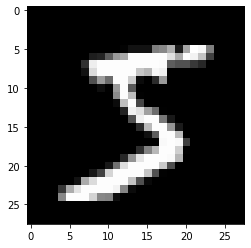

In [388]:
x_train, y_train, x_test, y_test = process_mnist_data()
img = x_train[0].reshape(28, 28, 1)
plt.imshow(img, cmap='gray')

In [389]:
model = parse_input_model()
mnist_batch_1 = x_train[0:32].reshape(32, 1, 28, 28)
mnist_labels_1 = y_train[0:32]
mnist_batch_1.shape

(32, 1, 28, 28)

In [390]:
# train
mnist_subsample_x = x_train[:4992]
mnist_subsample_y = y_train[:4992]
# validation
mnist_validation_x = x_test[:2000]
mnist_validation_y = y_test[:2000]
# test
mnist_test_x = x_test[5001:7001]
mnist_test_y = y_test[5001:7001]

In [391]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(0,10))

LabelBinarizer()

In [392]:
validation_batch = mnist_validation_x.reshape(2000, 1, 28, 28)
validation_labels = label_binarizer.transform(mnist_validation_y)

In [393]:
validation_labels[0:100]

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0,

In [394]:
test_batch = mnist_test_x.reshape(2000, 1, 28, 28)
test_labels = label_binarizer.transform(mnist_test_y)

In [395]:
test_labels[0:100]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0,

In [396]:
def measure_accuracy(y_true, y_pred):
    accurate = np.sum(np.all(y_true == y_pred, axis=1))
    total = y_true.shape[0]
    return accurate / total

In [397]:
def predict_labels(a):
    return (a == a.max(axis=1)[:,None]).astype(int)

In [398]:
%%timeit
inp = mnist_batch_1
for layer in model:
    inp = layer.forward(inp)

labels_true = label_binarizer.transform(mnist_labels_1)
l = loss_function(labels_true, inp)

out = labels_true
for layer in reversed(model):
    out = layer.backward(out)

3.3 s ± 28.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [399]:
# for i in range(10):
#     losses = []
#     index = [i for i in range(1,157)]
#     for j in range(0, 4992, 32):
#         batch_x = mnist_subsample_x[j:j+32].reshape(32, 1, 28, 28)
#         batch_y = mnist_subsample_y[j:j+32]
#         model_out = batch_x
#         # train
#         for layer in model:
#             # print(layer)
#             model_out = layer.forward(model_out)
#             # print(model_out.shape)
#
#         true_labels = label_binarizer.transform(batch_y)
#         l = loss_function(true_labels, model_out)
#         losses.append(l)
#         # print("Epoc {} batch {} loss = {}".format(i, j//32, l))
#
#
#
#         model_back = true_labels
#         for layer in reversed(model):
#             # print(layer)
#             model_back = layer.backward(model_back)
#             # print(model_back.shape)
#
#     plt.plot(index, losses)
#     plt.show()
#
#     #validation
#     # validation_out = validation_batch
#     # for layer in model:
#     #     validation_out = layer.forward(validation_out)
#     # validation_loss = loss_function(validation_labels, validation_out)
#     # print('Validation loss after epoc {} is {}'.format(i, validation_loss))
#     # validation_predictions = predict_labels(validation_out)
#     # accuracy = measure_accuracy(validation_labels, validation_predictions)
#     # print('Validation accuracy after epoc {} is {}'.format(i, accuracy))